# **import needed modules¶**


In [33]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

/tmp/ipykernel_32/3992008130.py:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# **gather the image files into a data frame¶**


In [34]:
import os
import pandas as pd
import random

sdir_fake = r'/kaggle/input/money-data/JD_Money/Fake'
sdir_real = r'/kaggle/input/money-data/JD_Money/Real'

def get_merged_filepaths_and_labels(directory, label):
    filepaths = []
    labels = []
    classes = os.listdir(directory)
    for klass in classes:
        classpath = os.path.join(directory, klass)
        if os.path.isdir(classpath):
            filelist = os.listdir(classpath)
            merged_filepaths = []
            merged_labels = []
            for f in filelist:
                fpath = os.path.join(classpath, f)
                merged_filepaths.append(fpath)
                merged_labels.append(label)
            filepaths.extend(merged_filepaths)
            labels.extend(merged_labels)
    return filepaths, labels

# Get merged file paths and labels for Fake
fake_filepaths, fake_labels = get_merged_filepaths_and_labels(sdir_fake, 'Fake')

# Get merged file paths and labels for Real
real_filepaths, real_labels = get_merged_filepaths_and_labels(sdir_real, 'Real')

# Randomly downsample the larger class to match the size of the smaller class
min_class_size = min(len(fake_filepaths), len(real_filepaths))
fake_filepaths = random.sample(fake_filepaths, min_class_size)

# Combine file paths and labels
filepaths = fake_filepaths + real_filepaths
labels = ['Fake'] * min_class_size + ['Real'] * min_class_size

# Creating the DataFrame
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

print('Number of files:', len(filepaths))
print('Number of labels:', len(labels))
print(df.head())

# Check the balance
balance = df['labels'].value_counts()
print(balance)

Number of files: 1106
Number of labels: 1106
                                           filepaths labels
0  /kaggle/input/money-data/JD_Money/Fake/fack fi...   Fake
1  /kaggle/input/money-data/JD_Money/Fake/fack fi...   Fake
2  /kaggle/input/money-data/JD_Money/Fake/fack fi...   Fake
3  /kaggle/input/money-data/JD_Money/Fake/fack on...   Fake
4  /kaggle/input/money-data/JD_Money/Fake/fack te...   Fake
labels
Fake    553
Real    553
Name: count, dtype: int64


# **check the balance of the dataset¶**


In [35]:
balance=df['labels'].value_counts()
print (balance)

labels
Fake    553
Real    553
Name: count, dtype: int64


# **split df into train, test and valid dataframe¶**


In [36]:
train_split=.7
test_split=.15
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df= train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train size: ', len(train_df), '  test size: ', len(test_df), '   valid size: ', len(valid_df))
length=len(test_df)

train size:  774   test size:  165    valid size:  167


# **create train, test andvalid generators¶**


In [37]:
batch_size=84
augmented_batch_size = 3
num_augmented_images = augmented_batch_size * 2  # Each image will be transformed into 5 images
def scalar(x):
    return x/127.5-1 # rescales pixels to range -1 to +1
trgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True,vertical_flip=True,shear_range=0.2,rotation_range=45,zoom_range=0.2 )
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='binary',
                                   batch_size=batch_size, shuffle=True, seed=123)
tvgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar)
valid_gen=tvgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='binary',
                                   batch_size=batch_size, shuffle=False)
# determine test generator batch size and steps to go through the test set exactly once for predictions
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]
test_steps=int(length/test_batch_size)
test_gen=tvgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=(224,224), class_mode='binary',
                                   batch_size=test_batch_size, shuffle=False)
test_labels=test_gen.labels

Found 771 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 164 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 165 validated image filenames belonging to 2 classes.


In [38]:
num_train_images = len(train_gen.filenames) * num_augmented_images
num_valid_images = len(valid_gen.filenames)
num_test_images = len(test_gen.filenames)


print("Number of training images:", num_train_images)
print("Number of validation images:", num_valid_images)
print("Number of test images:", num_test_images)

Number of training images: 4626
Number of validation images: 164
Number of test images: 165


# **define function to show some images¶**


In [39]:
def show_training_samples(gen):
    class_dict=gen.class_indices
    new_dict={}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value]=key
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(15, 15))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=new_dict[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

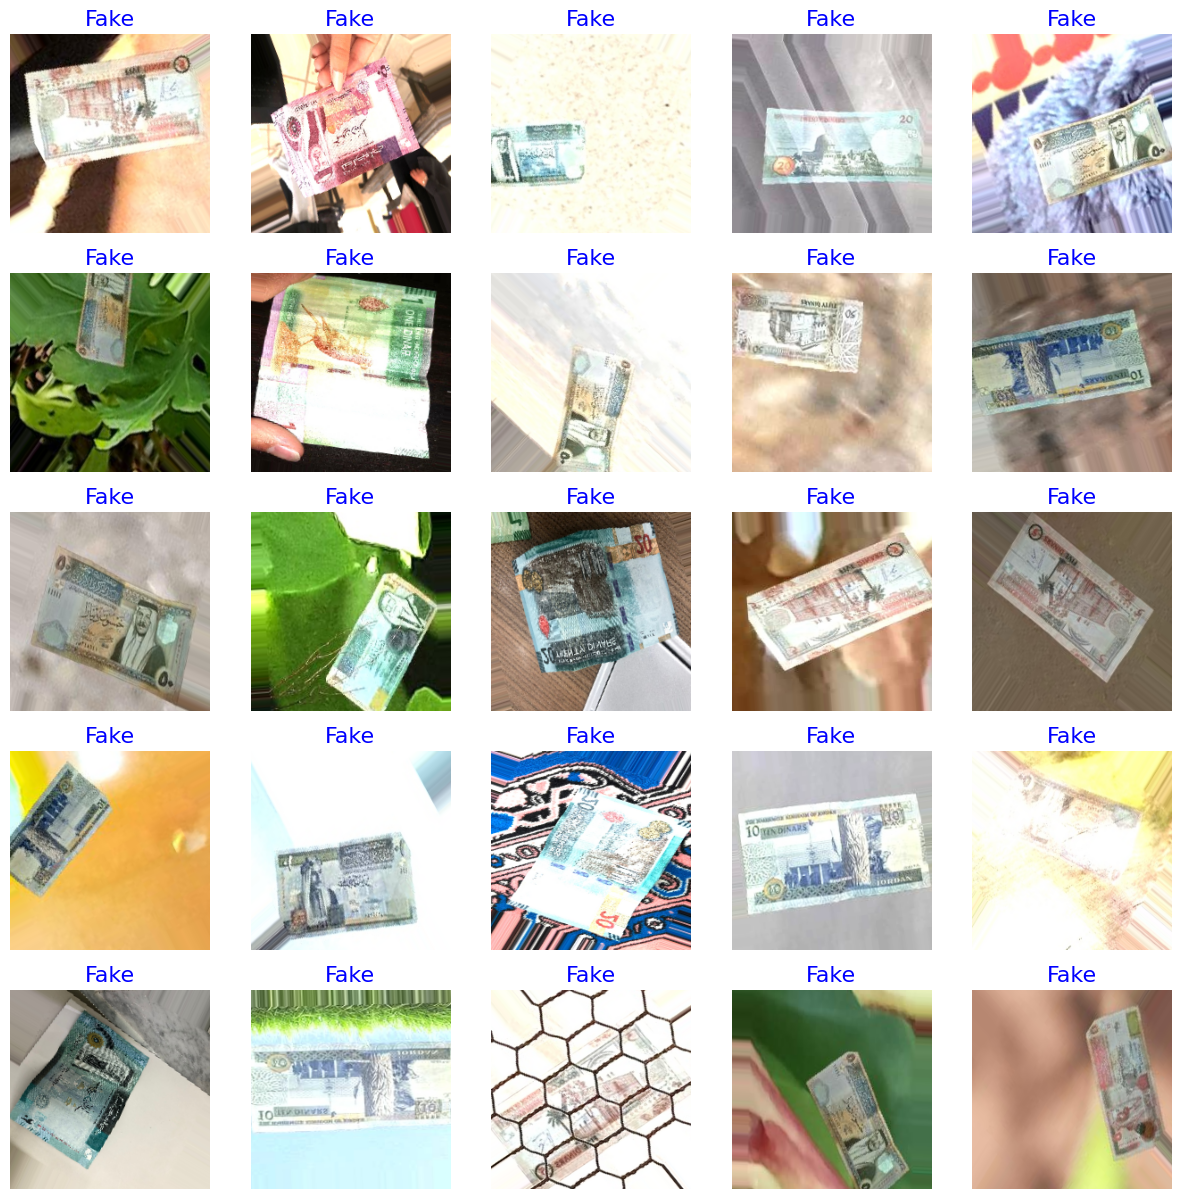

In [40]:
show_training_samples(train_gen)


# **create CNN¶**


In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ReLU, LeakyReLU, Flatten, Dense, Dropout, GlobalAveragePooling2D, Multiply, Add, Reshape
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras.optimizers import Adam
import random

image_shape = [224, 224, 3]

# Define the input layer
input_layer = Input(shape=image_shape)

# First Convolutional Block
x = Conv2D(16, kernel_size=(3, 3))(input_layer)
activation_choice = random.choice([ReLU(), LeakyReLU()])
x = activation_choice(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Second Convolutional Block
x = Conv2D(32, kernel_size=(3, 3))(x)
activation_choice = random.choice([ReLU(), LeakyReLU()])
x = activation_choice(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Third Convolutional Block
x = Conv2D(64, kernel_size=(3, 3))(x)
activation_choice = random.choice([ReLU(), LeakyReLU()])
x = activation_choice(x)

# Channel Attention Module (CAM)
avg_pool = GlobalAveragePooling2D()(x)
max_pool = MaxPooling2D(pool_size=(x.shape[1], x.shape[2]))(x)  # Perform global max pooling
channel_attention = Add()([avg_pool, max_pool])
channel_attention = Dense(64, activation='relu')(channel_attention)
channel_attention = Dense(1, activation='sigmoid')(channel_attention)  # Reduce to 1 channel
channel_attention = Multiply()([x, channel_attention])

# Spatial Attention Module (SAM)
avg_pool_spatial = GlobalAveragePooling2D()(x)
max_pool_spatial = MaxPooling2D(pool_size=(x.shape[1], x.shape[2]))(x)  # Perform global max pooling
spatial_attention = Add()([avg_pool_spatial, max_pool_spatial])
spatial_attention = Dense(64, activation='relu')(spatial_attention)
spatial_attention = Dense(1, activation='sigmoid')(spatial_attention)  # Reduce to 1 channel
spatial_attention = Multiply()([x, spatial_attention])


# Attention Mechanism (2D)
attention = Conv2D(1, (3, 3), activation='sigmoid', padding='SAME')(x)
attention = Reshape((52, 52, 1))(attention)  # Adjust the shape to match the feature map size
x = Multiply()([x, attention])

x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten
x = Flatten()(x)

# Rest of your model
x = Dense(256)(x)
activation_choice = random.choice([ReLU(), LeakyReLU()])
x = activation_choice(x)
x = Dropout(0.5)(x)

# Output Layer
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output)

optimizer_choice = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer_choice, metrics=['accuracy'])

# Rest of your code (callbacks, training) remains the same
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=4, mode='min')
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

results = model.fit(train_gen, epochs=30, validation_data=valid_gen, callbacks=[early_stop])

Epoch 1/30
10/10 [==============================] - 17s 1s/step - loss: 0.6960 - accuracy: 0.6952 - val_loss: 0.3953 - val_accuracy: 0.8049
Epoch 2/30
10/10 [==============================] - 13s 1s/step - loss: 0.4105 - accuracy: 0.8119 - val_loss: 0.3334 - val_accuracy: 0.8354
Epoch 3/30
10/10 [==============================] - 13s 1s/step - loss: 0.3561 - accuracy: 0.8547 - val_loss: 0.2723 - val_accuracy: 0.8841
Epoch 4/30
10/10 [==============================] - 13s 1s/step - loss: 0.2982 - accuracy: 0.8911 - val_loss: 0.2850 - val_accuracy: 0.8902
Epoch 5/30
10/10 [==============================] - 13s 1s/step - loss: 0.2640 - accuracy: 0.8975 - val_loss: 0.1694 - val_accuracy: 0.9207
Epoch 6/30
10/10 [==============================] - 13s 1s/step - loss: 0.2524 - accuracy: 0.9027 - val_loss: 0.1752 - val_accuracy: 0.9268
Epoch 7/30
10/10 [==============================] - 13s 1s/step - loss: 0.2334 - accuracy: 0.9131 - val_loss: 0.1415 - val_accuracy: 0.9451
Epoch 8/30
10/10 [==

In [42]:
# Generate predictions on the validation set
y_pred = model.predict(valid_gen)

# Extract the true labels from the validation generator
y_true = valid_gen.classes  # Assuming you're using ImageDataGenerator

# Convert predicted probabilities to binary labels
y_pred = (y_pred > 0.5).astype(int)

# Print the classification report
print(classification_report(y_true, y_pred))

2/2 [==============================] - 1s 443ms/step
              precision    recall  f1-score   support

           0       0.96      0.95      0.96        84
           1       0.95      0.96      0.96        80

    accuracy                           0.96       164
   macro avg       0.96      0.96      0.96       164
weighted avg       0.96      0.96      0.96       164



In [50]:
# Save the entire model to an HDF5 file
model.save('full_99model.h5')

In [51]:
best_optimizer_choice = optimizer_choice
best_activation_choice = activation_choice.__class__.__name__

print("Best Optimizer Choice:", best_optimizer_choice)
print("Best Activation Choice:", best_activation_choice)

Best Optimizer Choice: <keras.optimizers.adam.Adam object at 0x7f3e2b93d4b0>
Best Activation Choice: ReLU


In [52]:
import pandas as pd
loss_df = pd.DataFrame(model.history.history)
loss_df.columns

RangeIndex(start=0, stop=0, step=1)

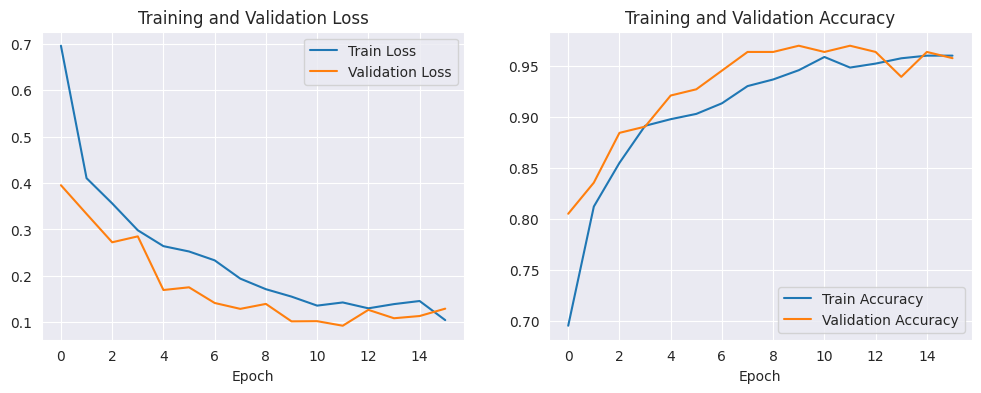

In [53]:

# Extract training and validation loss and accuracy
train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_accuracy = results.history['accuracy']
val_accuracy = results.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

# Show the plots
plt.show()

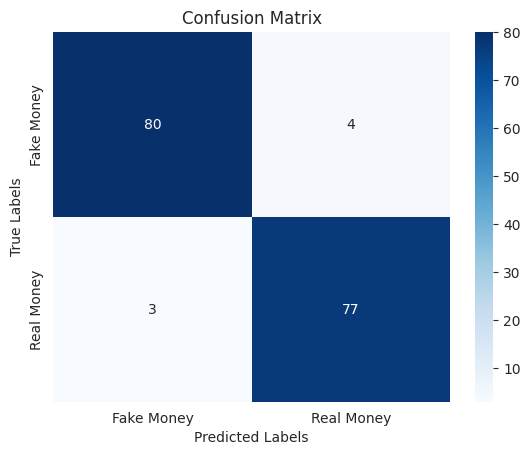

In [54]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix heatmap
class_names = ['Fake Money', 'Real Money']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

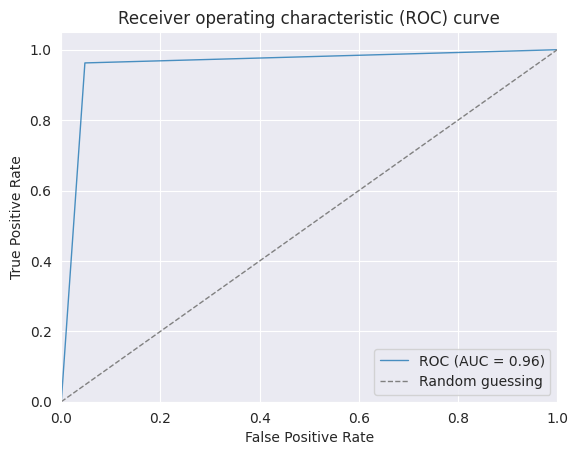

In [55]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.8, label='ROC (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

1/1 [==============================] - 0s 22ms/step


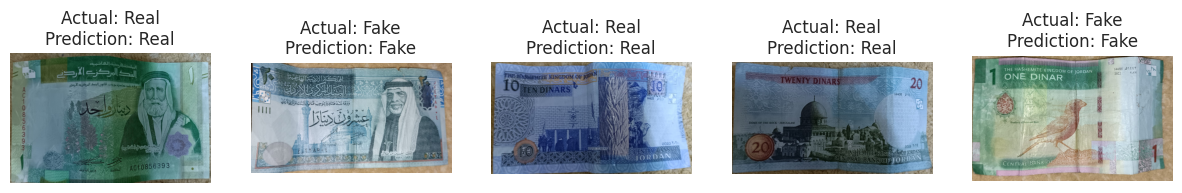

In [56]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model('/kaggle/working/full_99model.h5')

# Define a function to preprocess an image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, (224, 224))  # Resize to your model's input size
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Define a function to predict real or fake
def predict_real_or_fake(image_path):
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)  # Add a batch dimension
    prediction = model.predict(image)
    return prediction

# List of image paths to predict
image_paths = ['/kaggle/input/prediction/1 R.jpg', '/kaggle/input/prediction/20 F.jpg', '/kaggle/input/prediction/10 R.jpg', '/kaggle/input/prediction/20 R.jpg', '/kaggle/input/prediction/1 F.jpg']
actual_labels = ["Actual: Real", "Actual: Fake", "Actual: Real", "Actual: Real", "Actual: Fake"]

# Create subplots to display images and actual labels side by side
fig, axs = plt.subplots(1, len(image_paths), figsize=(15, 5))

for i, (image_path, actual_label) in enumerate(zip(image_paths, actual_labels)):
    prediction = predict_real_or_fake(image_path)
    
    if prediction >= 0.5:
        result = 'Real'
    else:
        result = 'Fake'
    
    # Display the image and actual label side by side
    image = cv2.imread(image_path)
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[i].set_title(f'{actual_label}\nPrediction: {result}')
    axs[i].axis('off')

plt.show()